## Separate inversion of the two synthetic AEM data

In [90]:
import dill 
import numpy as np
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps
from SimPEG.electromagnetics.utils.em1d_utils import get_2d_mesh, get_vertical_discretization
from pymatsolver import PardisoSolver


aem_data_dict = dill.load(open("synthetic_aem_data.pik", "rb"))
source_locations = aem_data_dict['source_locations']
receiver_locations = aem_data_dict['receiver_locations']
topo = aem_data_dict['topo']
times = aem_data_dict['times']
dobs_1 = aem_data_dict['data_1']
dobs_2 = aem_data_dict['data_2']
receiver_orientation = "z"                    # "x", "y" or "z"
source_list = []
n_sounding = topo.shape[0]


for i_sounding in range(n_sounding):    
    source_location = source_locations[i_sounding,:]
    receiver_location = receiver_locations[i_sounding,:]

    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_location, times, orientation=receiver_orientation
        )
    ]

    # General Waveform
    source_list.append(
        tdem.sources.MagDipole(
            receiver_list=receiver_list, location=source_location,
            waveform=tdem.sources.StepOffWaveform(), orientation='z',
            i_sounding=i_sounding
        ),
    )

# Survey
survey = tdem.Survey(source_list)

In [91]:
hz = np.array([30, 50, 20, 60, 60])

In [163]:
survey = tdem.Survey(source_list)
thicknesses = hz[:-1]
mesh = get_2d_mesh(n_sounding, hz)
sigma_map = maps.ExpMap(mesh)
# sigma_map = maps.IdentityMap(mesh)

simulation = tdem.Simulation1DLayeredStitched(
    survey=survey, thicknesses=thicknesses, sigmaMap=sigma_map,
    topo=topo, parallel=True, n_cpu=4, verbose=False, solver=PardisoSolver
)

>> Use multiprocessing for parallelization
>> n_cpu: 4


In [164]:
topo.shape

(91, 3)

In [165]:
import matplotlib.pyplot as plt

In [166]:
from SimPEG.electromagnetics.utils.em1d_utils import set_mesh_1d
import scipy as sp
from discretize import SimplexMesh
tmp = topo[:,:2]+np.random.randn(topo[:,:2].shape[0], topo[:,:2].shape[1])
tri = sp.spatial.Delaunay(tmp) 
mesh_radial = SimplexMesh(tri.points, tri.simplices)
mesh_vertical = set_mesh_1d(hz)
mesh_reg = [mesh_radial, mesh_vertical]

In [167]:
def get_active_edge_indices_with_distance(mesh_radial, mesh_vertical, maximum_distance=10):
    nz = mesh_vertical.n_cells
    edge_lengths = mesh_radial.edge_lengths
    inds = edge_lengths < maximum_distance
    indActiveEdges = np.tile(inds.reshape([-1,1]), nz).flatten()
    return inds, indActiveEdges

inds, indActiveEdges = get_active_edge_indices_with_distance(
    mesh_radial, mesh_vertical, maximum_distance=150
)
fr = mesh_radial.nodes[mesh_radial._edges[inds,:][:,0],:]
to = mesh_radial.nodes[mesh_radial._edges[inds,:][:,1],:]

(-1000.0, 1000.0)

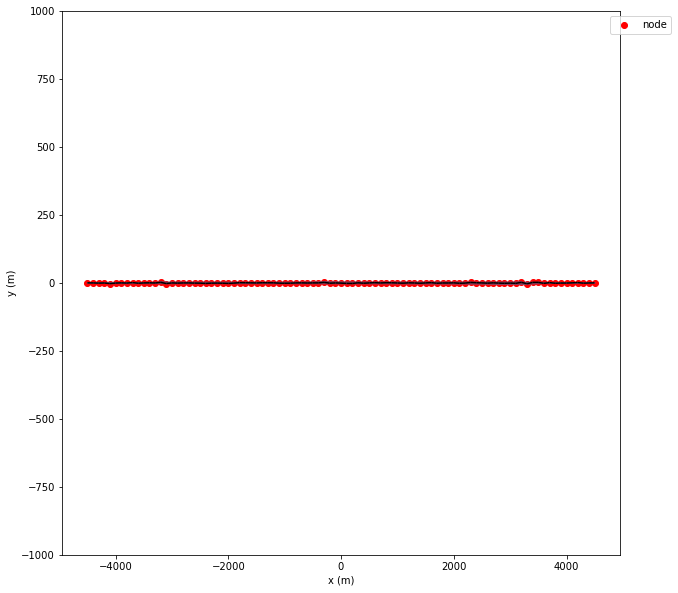

In [169]:
fig = plt.figure(figsize=(10, 10))
plt.plot(mesh_radial.nodes[:,0], mesh_radial.nodes[:,1], 'ro', label='node', zorder=1)
plt.triplot(tmp[:,0], tmp[:,1], tri.simplices[:,:], alpha=0.5, lw=1)

for ii in range(fr.shape[0]):
    plt.plot([fr[ii,0], to[ii,0]], [fr[ii,1], to[ii,1]], 'k--')

plt.legend(bbox_to_anchor=(1.1,1))
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.ylim(-1000, 1000)
# plt.gca().set_aspect(1)

In [171]:
from SimPEG import (
    maps, data, data_misfit, inverse_problem, regularization, optimization,
    directives, inversion, utils
)
nP = mesh.n_cells
data_object = data.Data(survey, dobs=dobs_1)
uncertainties = abs(dobs_1.reshape((n_sounding, times.size))) * 0.03
uncertainties[:,:13] = 1e9
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1./uncertainties.flatten()

regmap = maps.IdentityMap(nP=nP)

reg = regularization.LaterallyConstrained(
    mesh_reg, 
    mapping=regmap,
    alpha_s = 1.,
    alpha_r = 1.,
    alpha_z = 0.,
    indActiveEdges=indActiveEdges
)

reg_s = reg.objfcts[0]
weights = np.ones((n_sounding, hz.size)) * 1e-1
weights[:, [0, 2, 4]] = 1.
rho_ref = np.ones((n_sounding, hz.size)) * 50.
rho_ref[:, [0, 2, 4]] = 15.
reg_s.cell_weights = weights.flatten()
reg.mref = np.log(1./rho_ref.flatten())

opt = optimization.ProjectedGNCG(maxIter=10, maxIterCG=20)
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
beta = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = directives.TargetMisfit(chifact=1.)
save_model = directives.SaveOutputDictEveryIteration()
inv = inversion.BaseInversion(invProb, directiveList=[beta, betaest, target, save_model])
invProb.counter = opt.counter = utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
rho_initial = np.ones(nP) * 20.
m0 = np.log(1./rho_ref.flatten())
mest = inv.run(m0)
outdict = save_model.outDict


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.40e+01  3.67e+05  0.00e+00  3.67e+05    1.84e+04      0              
   1  3.20e+01  2.35e+05  4.15e+02  2.48e+05    1.63e+04      0              
   2  1.60e+01  7.10e+04  1.81e+03  1.00e+05    6.08e+04      0              
   3  8.01e+00  5.82e+03  1.57e+03  1.84e+04    7.07e+03      0              
   4  4.00e+00  3.18e+03  1.62e+03  9.65e+03    1.46e+03      0   Skip BFGS  
   5  2.00e+00  2.70e+03  1.68e+03  6.07e+03    5.56e+02      0   Skip BFGS  
   6  1.00e+00  2.38e+03  1.79e+03  4.17e+03    3.49e+02      0   Skip BFGS  
------------------------- STOP! --

In [172]:
xc = opt.recall('xc')

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\utils\em1d_utils.py:536: UserWarning: code under construction - API might change in the future
  warnings.warn(


(<matplotlib.collections.QuadMesh at 0x1c9c5b062b0>,
 <AxesSubplot:xlabel='Easting (m)', ylabel='Elevation (m)'>,
 <matplotlib.colorbar.Colorbar at 0x1c9c5b95d60>)

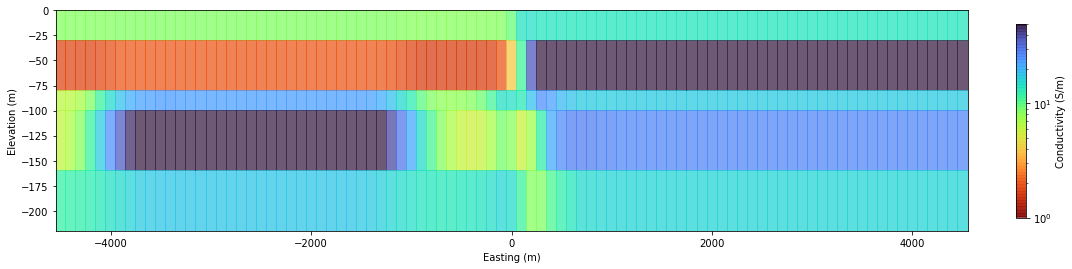

In [173]:
from SimPEG.electromagnetics.utils.em1d_utils import Stitched1DModel
rho_inv = 1./np.exp(mest)
model = Stitched1DModel(
    hz=hz[:].astype(float), 
    line=np.ones(n_sounding), 
    topography=topo,
    time_stamp=np.arange(n_sounding).astype(float), 
    physical_property=rho_inv.reshape((n_sounding, hz.size))[:,:].flatten()
)
model.plot_section(i_line=0, x_axis='x', aspect=10, cmap='turbo_r', clim=(1, 50), dx=50)

In [174]:
times.shape

(41,)

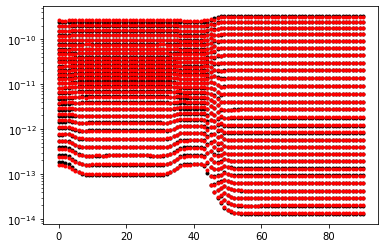

In [175]:
_ = plt.semilogy(-dobs_1.reshape((n_sounding, times.size))[:,13:], 'k.')
_ = plt.semilogy(-invProb.dpred.reshape((n_sounding, times.size))[:,13:], 'r.')

In [176]:
nP = mesh.n_cells
data_object = data.Data(survey, dobs=dobs_1)
uncertainties = abs(dobs_1.reshape((n_sounding, times.size))) * 0.03
uncertainties[:,:13] = 1e9
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1./uncertainties.flatten()

regmap = maps.IdentityMap(nP=nP)

reg = regularization.LaterallyConstrained(
    mesh_reg, 
    mapping=regmap,
    alpha_s = 1.,
    alpha_r = 1.,
    alpha_z = 0.,
    indActiveEdges=indActiveEdges
)

reg_s = reg.objfcts[0]
weights = np.ones((n_sounding, hz.size)) * 1e-1
weights[:, [0, 2, 4]] = 1.
rho_ref = np.ones((n_sounding, hz.size)) * 50.
rho_ref[:, [0, 2, 4]] = 15.
reg_s.cell_weights = weights.flatten()
reg.mref = np.log(1./rho_ref.flatten())

opt = optimization.ProjectedGNCG(maxIter=20, maxIterCG=20)
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
beta = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e-2)
target = directives.TargetMisfit(chifact=1.)
save_model = directives.SaveOutputDictEveryIteration()

p = 1
qr, qz = 0., 0.
reg.norms = np.c_[p, qr, qz, 0.]
irls = directives.Update_IRLS(
    max_irls_iterations=30, minGNiter=1, fix_Jmatrix=False, f_min_change=1e-3
)
inv = inversion.BaseInversion(invProb, directiveList=[betaest, irls, save_model])
invProb.counter = opt.counter = utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
m_lp = inv.run(mest)
outdict = save_model.outDict
xc = opt.recall('xc')

C:\Users\sgkan\Projects\simpeg\SimPEG\directives\directives.py:1471: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  warnings.warn(



        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.61e-01  1.79e+03  2.07e+03  3.36e+03    4.64e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 3.3726985594200016 eps_q: 3.3726985594200016
   1  3.80e-01  1.45e+03  2.54e+03  2.42e+03    2.80e+02      0              
   2  6.45e-01  1.34e+03  2.78e+03  3.14e+03    2.54e+02      0              
   3  1.07e+00  1.43e+03  2.70e+03  4.30e+03    3.34e+02      0              
   4  1.69e+00  1.58e+03  2.64e+03  6.05e+03    2.87e+02      0              
   5  1.69e+00  1.78e+03  2.63e+03  6.23e+03    1.83e+02      0 

(<matplotlib.collections.QuadMesh at 0x1c9c8aac3d0>,
 <AxesSubplot:xlabel='Easting (m)', ylabel='Elevation (m)'>,
 <matplotlib.colorbar.Colorbar at 0x1c9c8b71af0>)

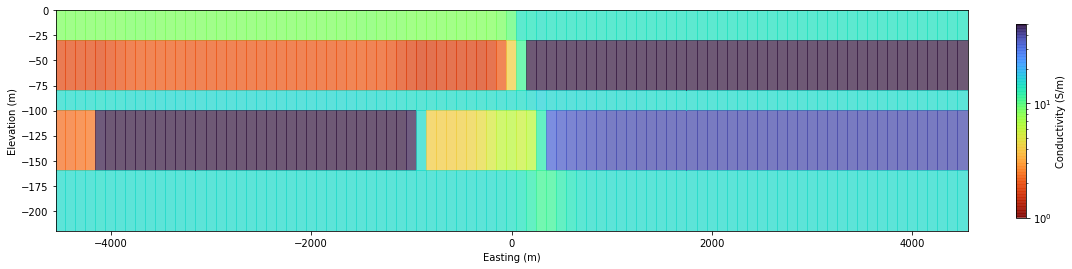

In [177]:
model.plot_section(i_line=0, x_axis='x', aspect=10, cmap='turbo_r', clim=(1, 50), dx=50, physical_property=1./np.exp(m_lp))